In [19]:
#NOTE IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
import pandas as pd # Dataframe
import seaborn as sns # Boxplot

In [ ]:
#NOTE CONSTANTS

AZIMUTH_MIN     = -180 # "under"-rotation
AZIMUTH_MAX     = 540 # with over-rotation
ELEVATION_MIN   = 15 # balcony ground collision at <=14°
ELEVATION_MAX   = 165 # flip-over
AZ_SPEED        = 1.6 # degrees per second, practically tested
EL_SPEED        = 1.3


waypoints = [
    #AZ     EL
    (0,     15), # parking position
    (350,   30),
    (180,   85),
    (0,     85),
    (90,    60),
    (10,    20),
    (270,   80),
    (45,    40),
    (165,   40),
]

In [21]:
#NOTE COORDINATE TRANSFORMATION

def azel_to_cartesian(az_deg: float, el_deg: float) -> np.ndarray:
    az = np.radians(az_deg)
    el = np.radians(el_deg)
    # standard unit spherical coordinates
    x = np.cos(el) * np.cos(az)
    y = np.cos(el) * np.sin(az)
    z = np.sin(el)
    return np.array([x, y, z])


def cartesian_to_azel(vec: np.ndarray) -> Tuple[float, float]:
    x, y, z = vec
    hyp = np.hypot(x, y) # hypotenuse = sqrt(x**2 + y**2)
    az = np.degrees(np.arctan2(y, x)) % 360 # full-circle azimuth
    el = np.degrees(np.arctan2(z, hyp))
    return az, el


def azel_to_polar(az_deg: float, el_deg: float) -> Tuple[float, float]:
    if el_deg > 90:
        el_deg = 180 - el_deg # flip over adjusting
    theta = np.radians(az_deg % 360)
    radius = 90 - el_deg # center = el_90
    return theta, radius

In [22]:
#NOTE SLERP

def slerp_path(start_az: float, start_el: float, end_az: float, end_el: float, steps: int = 1000) -> List[Tuple[float, float]]:
    # convert to 3D vectors
    p0 = azel_to_cartesian(start_az, start_el)
    p1 = azel_to_cartesian(end_az, end_el)

    # angle between start/end vector in radians
    # dot product of 2 unit vectors => cos(omega) (since theta will be used for polar)
    omega = np.arccos(np.clip(np.dot(p0, p1), -1.0, 1.0)) # ensure it stays between -1 and 1

    # small angles ~ linear anyway
    if np.isclose(omega, 0):
        return [(start_az, start_el)] * steps

    # otherwise calculate steps along the path
    sin_omega = np.sin(omega)
    path = []

    # formula: point(t) = [sin((1-t)*omega)*p0 + sin(t*omega)*p1]/sin(omega) -> sin() = weights
    # no weights -> cut through circle, like |x| + |y| + |z|
    # interpolate along spherical arc
    for t in np.linspace(0, 1, steps):
        factor0 = np.sin((1-t) * omega) / sin_omega
        factor1 = np.sin(t * omega) / sin_omega
        pt = factor0 * p0 + factor1 * p1
        az, el = cartesian_to_azel(pt) # reverse coordinate after calculation of path
        path.append((az, el))
    return path

In [23]:
#NOTE AXIS ALIGNED PATH

def axis_aligned_paths(start: Tuple[float, float], end: Tuple[float, float]) -> List[Tuple[str, List[Tuple[float, float]]]]:
    paths = []
    az_s, el_s = start
    az_e, el_e = end

    az_path1 = slerp_path(az_s, el_s, az_e, el_s, steps=100)
    el_path1 = slerp_path(az_e, el_s, az_e, el_e, steps=100)
    paths.append(("AZ->EL", az_path1 + el_path1))

    az_path2 = slerp_path(az_s, el_s, az_s, el_e, steps=100)
    el_path2 = slerp_path(az_s, el_e, az_e, el_e, steps=100)
    paths.append(("EL->AZ", az_path2 + el_path2))

    return paths

In [ ]:
#NOTE SIMULTANEOUS PATH

def simultaneous_az_el_path(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> List[Tuple[float, float]]:
    az1, el1 = start
    az2, el2 = end

    delta_az = (az2 - az1 + 540) % 360 - 180
    az_end_adjusted = az1 + delta_az

    path = [
        (az1 + (az_end_adjusted - az1) * t, el1 + (el2 - el1) * t)
        for t in np.linspace(0, 1, steps)
    ]
    return path

In [25]:
#NOTE MOVEMENT TIME CALCULATION

def movement_time(start: Tuple[float, float], end: Tuple[float, float], sequential: bool = False) -> float:
    # Extract coordinates
    az_start, el_start = start
    az_end, el_end = end

    # Shortest distances for AZ/EL
    delta_az = min(abs(az_end - az_start), 360 - abs(az_end - az_start))
    delta_el = abs(el_end - el_start)

    time_az = delta_az / AZ_SPEED
    time_el = delta_el / EL_SPEED

    if sequential:
        return time_az + time_el # Separate movement
    else:
        return max(time_az, time_el) # Simultaneous AZ/EL movement


def slerp_path_time(path: List[Tuple[float, float]], sequential: bool = False) -> float:
    total_time = 0.0
    for i in range(1, len(path)):
        total_time += movement_time(path[i-1], path[i], sequential)
    return total_time


def axis_aligned_time(start: Tuple[float, float], end: Tuple[float, float]) -> Tuple[float, float]:
    az_to_el = (
        movement_time(start, (end[0], start[1]), sequential=False) + movement_time((end[0], start[1]), end, sequential=False)
        )

    el_to_az = (
        movement_time(start, (start[0], end[1]),sequential=False) + movement_time((start[0], end[1]), end, sequential=False)
    )
    return az_to_el, el_to_az

In [26]:
#NOTE MAIN, COLLECTS ALL PATHS

all_paths = []
for i in range(len(waypoints) -1): 
    start = waypoints[i]
    end = waypoints[i + 1]

    # SLERP path and time
    path_slerp = slerp_path(*start, *end, steps=500)
    time_slerp = slerp_path_time(path_slerp)
    all_paths.append({
        "From": start,
        "To": end,
        "Path Type": "SLERP",
        "Time (s)": round(time_slerp, 2),
        "Path": path_slerp
        })

    # Axis-aligned paths and times
    for name, path in axis_aligned_paths(start, end):
        time_axis = slerp_path_time(path, sequential=True)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": name,
            "Time (s)": round(time_axis, 2),
            "Path": path
        })

    # Simultaneous AZ+EL path
    path_simult = simultaneous_az_el_path(start, end, steps=500)
    time_simult = slerp_path_time(path_simult)
    all_paths.append({
        "From": start,
        "To": end,
        "Path Type": "AZ+EL Simult",
        "Time (s)": round(time_simult, 2),
        "Path": path_simult
    })

In [30]:
#NOTE DATAFRAME CONVERSION

df = pd.DataFrame(all_paths)
df["From"] = df["From"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))
df["To"] = df["To"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))

#print(df[["From", "To", "Path Type", "Time (s)"]].to_string(index=False))

# Statistics
# Group by coordinate pair -> select time column -> find index (row number) with minimum time -> loc selects actual rows after they are found
fastest_per_segment = df.loc[df.groupby(["From", "To"])["Time (s)"].idxmin()]
print(f"\nFastest per segment:\n{fastest_per_segment[["From", "To", "Path Type", "Time (s)"]]}")

# Best
win_counts = fastest_per_segment["Path Type"].value_counts()
print(f"\nWin counts by {win_counts}")

# Average Time per path type
avg_times = df.groupby("Path Type")["Time (s)"].mean().sort_values()
print(f"\nAverage Times:\n{avg_times}")


Fastest per segment:
         From         To     Path Type  Time (s)
0     (0, 15)  (350, 30)         SLERP     11.54
15    (0, 85)   (90, 60)  AZ+EL Simult     56.25
23   (10, 20)  (270, 80)  AZ+EL Simult     62.50
31   (45, 40)  (165, 40)  AZ+EL Simult     75.00
19   (90, 60)   (10, 20)  AZ+EL Simult     50.00
11  (180, 85)    (0, 85)  AZ+EL Simult    112.50
27  (270, 80)   (45, 40)  AZ+EL Simult     84.37
7   (350, 30)  (180, 85)  AZ+EL Simult    106.25

Win counts by Path Type
AZ+EL Simult    7
SLERP           1
Name: count, dtype: int64

Average Times:
Path Type
AZ+EL Simult     69.80125
SLERP            81.50125
EL->AZ          105.39500
AZ->EL          110.75000
Name: Time (s), dtype: float64


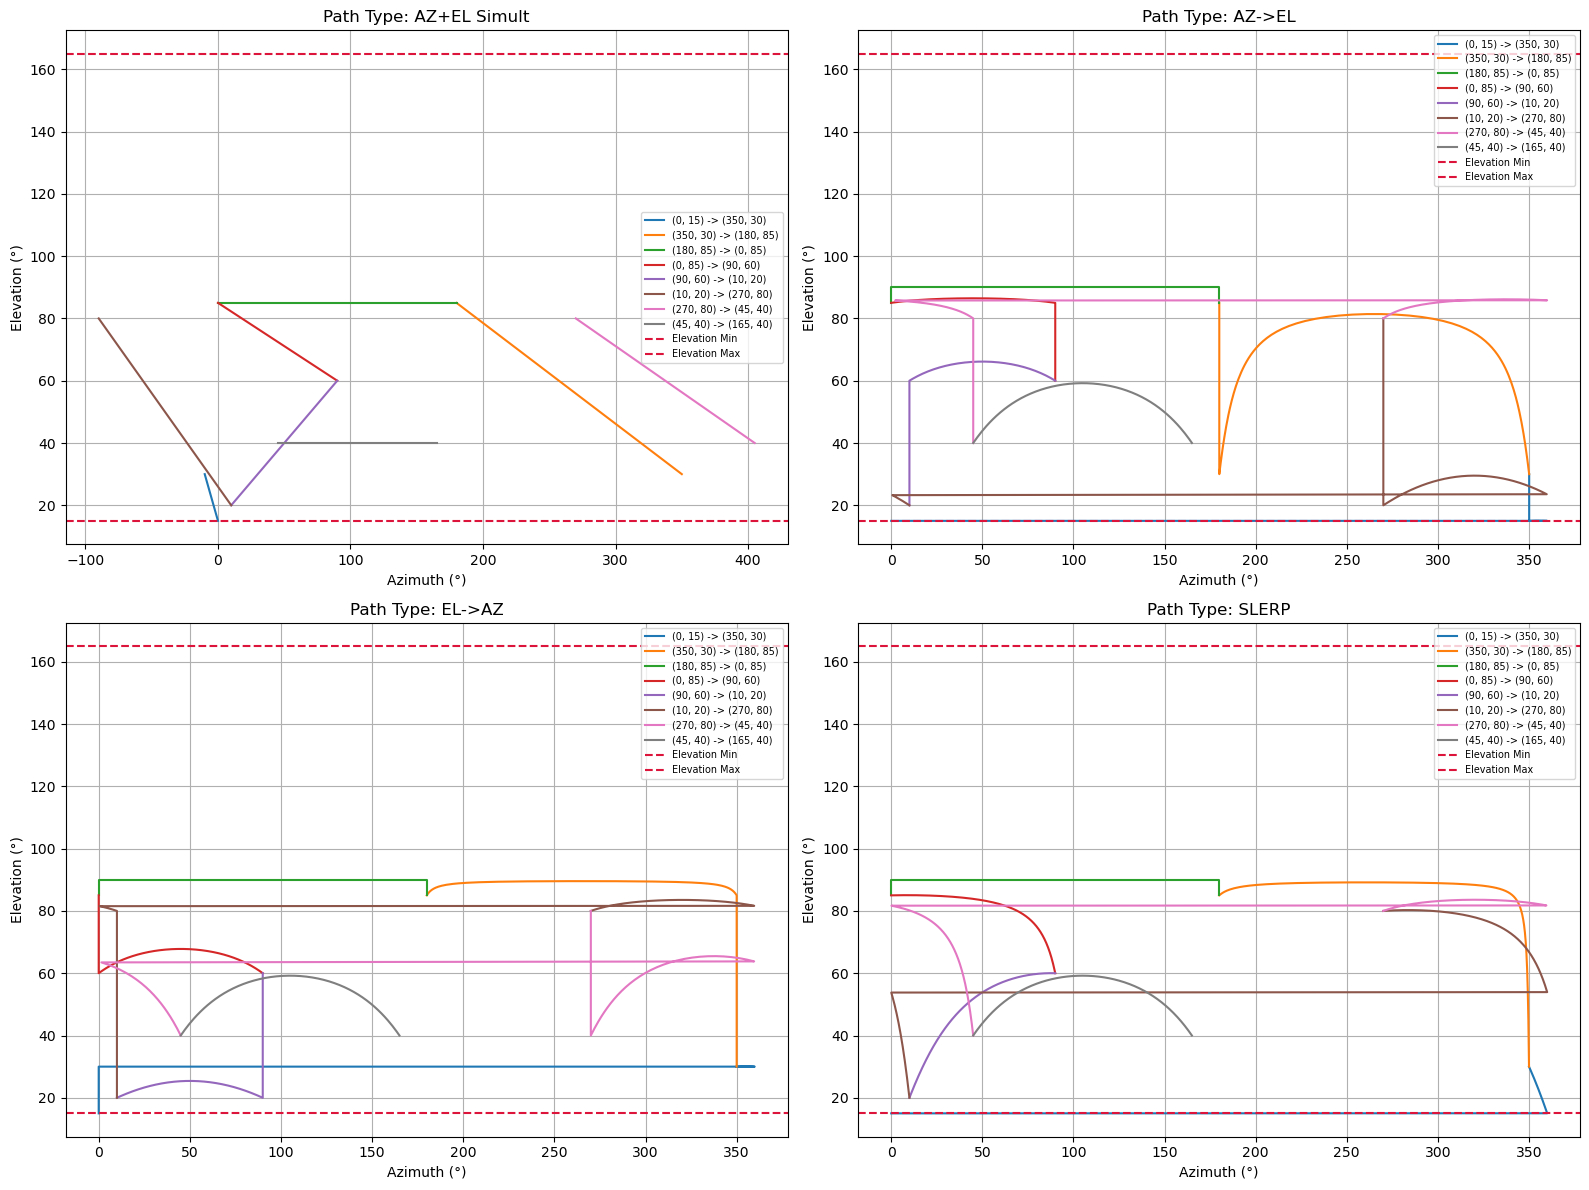

In [34]:
#NOTE 2D-AZEL-PROJECTED PLOT

path_types = sorted(set(entry["Path Type"] for entry in all_paths))

rows = 2
cols = int(np.ceil(len(path_types) / 2))
fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows), subplot_kw={"polar": False})
axes = axes.flat


for ax, path_type in zip(axes, path_types):
    for i, entry in enumerate(all_paths):
        if entry["Path Type"] == path_type:
            path = entry["Path"]
            az_list, el_list = zip(*path)
            ax.plot(az_list, el_list, label=f"{entry['From']} -> {entry['To']}")

    ax.set_title(f"Path Type: {path_type}")
    ax.set_xlabel("Azimuth (°)")
    ax.set_ylabel("Elevation (°)")
    ax.axhline(y=ELEVATION_MIN, color="crimson", linestyle="--", label="Elevation Min")
    ax.axhline(y=ELEVATION_MAX, color="crimson", linestyle="--", label="Elevation Max")
    ax.grid(True)
    ax.legend(fontsize="x-small")

plt.tight_layout()
plt.show()

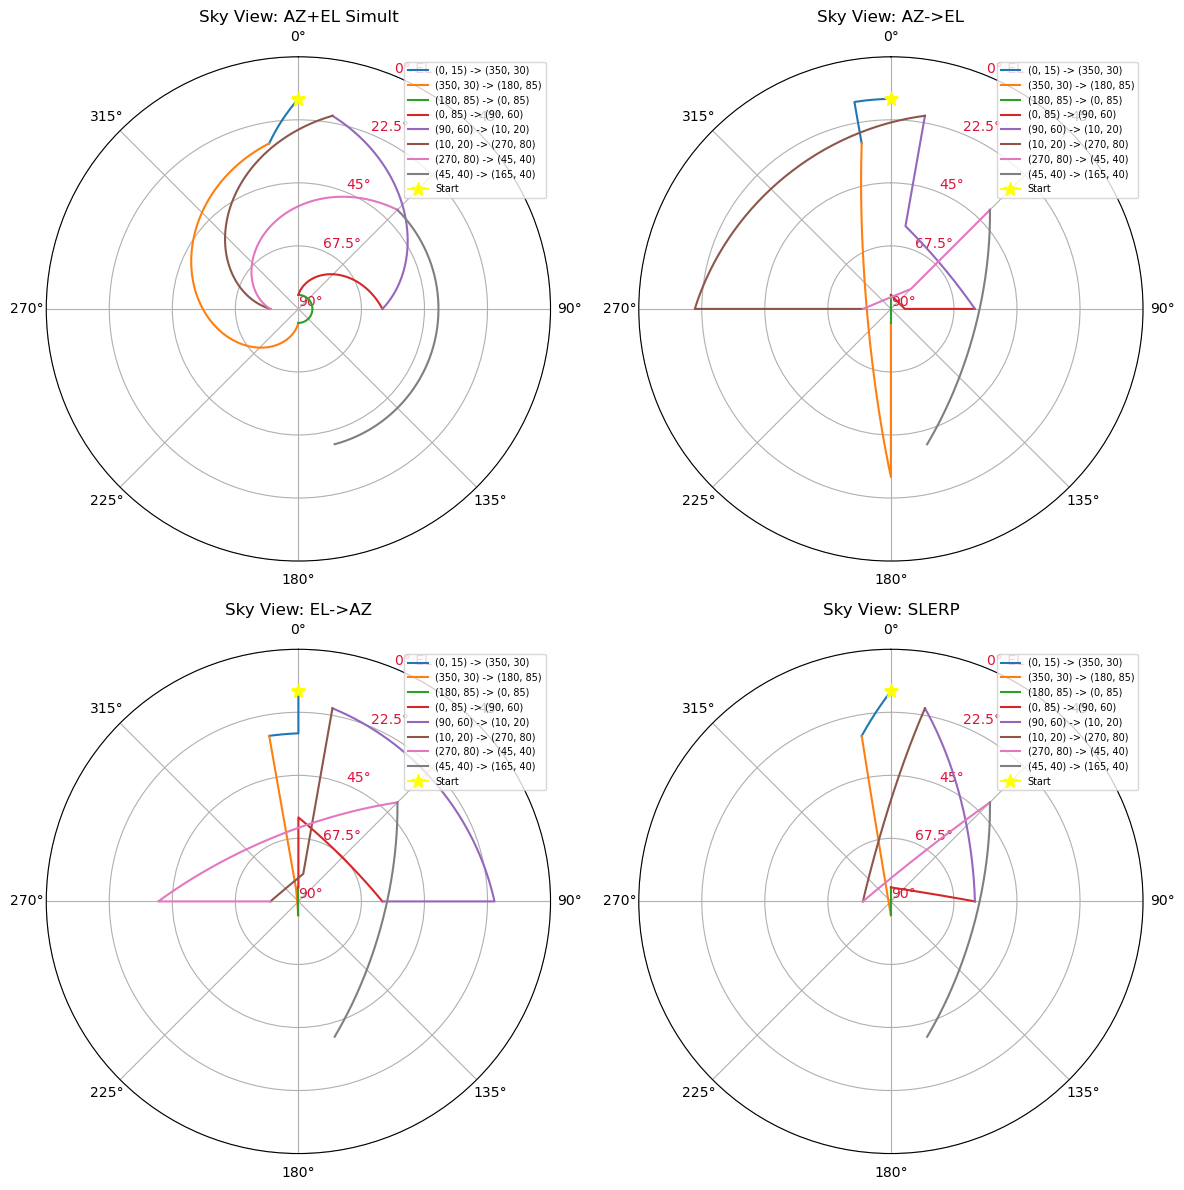

In [35]:
#NOTE POLAR-PROJECTED PLOTS

rows = 2
cols = int(np.ceil(len(path_types) / 2))
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), subplot_kw={"polar": True})
axes = axes.flat

for ax, path_type in zip(axes, path_types):
    for i, entry in enumerate(all_paths):
        if entry["Path Type"] == path_type:
            path = entry["Path"]
            theta_and_r = [azel_to_polar(az, el) for az, el in path]
            theta, r = zip(*theta_and_r)
            ax.plot(theta, r, label=f"{entry['From']} -> {entry['To']}")

    # Starting point
    theta0, r0 = azel_to_polar(*waypoints[0])
    ax.plot([theta0], [r0], marker="*", markersize=10, color="yellow", label="Start")

    # Subplot formatting
    ax.set_title(f"Sky View: {path_type}")
    ax.set_ylim(0, 75)
    ax.set_yticks([0, 22.5, 45, 67.5, 90])
    ax.set_yticklabels(["90°", "67.5°", "45°", "22.5°", "0° EL"])
    for label in ax.get_yticklabels():
        label.set_color("crimson")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)
    ax.legend(loc="upper right", fontsize="x-small")

plt.tight_layout()
plt.show()

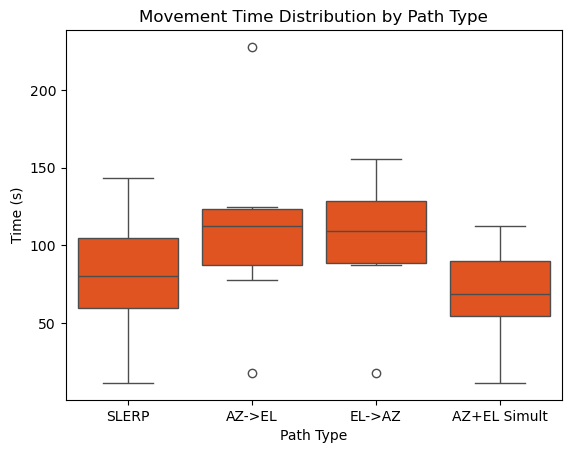

In [ ]:
#NOTE BOXPLOT

sns.boxplot(data=df, x="Path Type", y="Time (s)", color="orangered")
plt.title("Movement Time Distribution by Path Type")
plt.show()

In [40]:
#NOTE WAYPOINT GENERATOR + CALCULATING TIME FOR EACH WAYPOINT

def random_waypoints(n: int = 10) -> List[Tuple[float, float]]:
    az = np.random.uniform(0, 360, n)
    el = np.random.uniform(ELEVATION_MIN, ELEVATION_MAX, n)

    return list(zip(az, el))


def benchmark_segment(wps: List[Tuple[float, float]]):
    method_times = {
        "SLERP": [],
        "AZ->EL": [],
        "EL->AZ": [],
        "AZ+EL Simult": []
        }

    # Waypoint pairs for moving
    for i in range(len(wps) - 1):
        s, e = wps[i], wps[i + 1]

        method_times["SLERP"].append(slerp_path_time(slerp_path(*s, *e, steps=100)))

        azel_time, elaz_time = axis_aligned_time(s, e)
        method_times["AZ->EL"].append(azel_time)
        method_times["EL->AZ"].append(elaz_time)

        sim_path = simultaneous_az_el_path(s, e, steps=100)
        method_times["AZ+EL Simult"].append(slerp_path_time(sim_path))

    return method_times

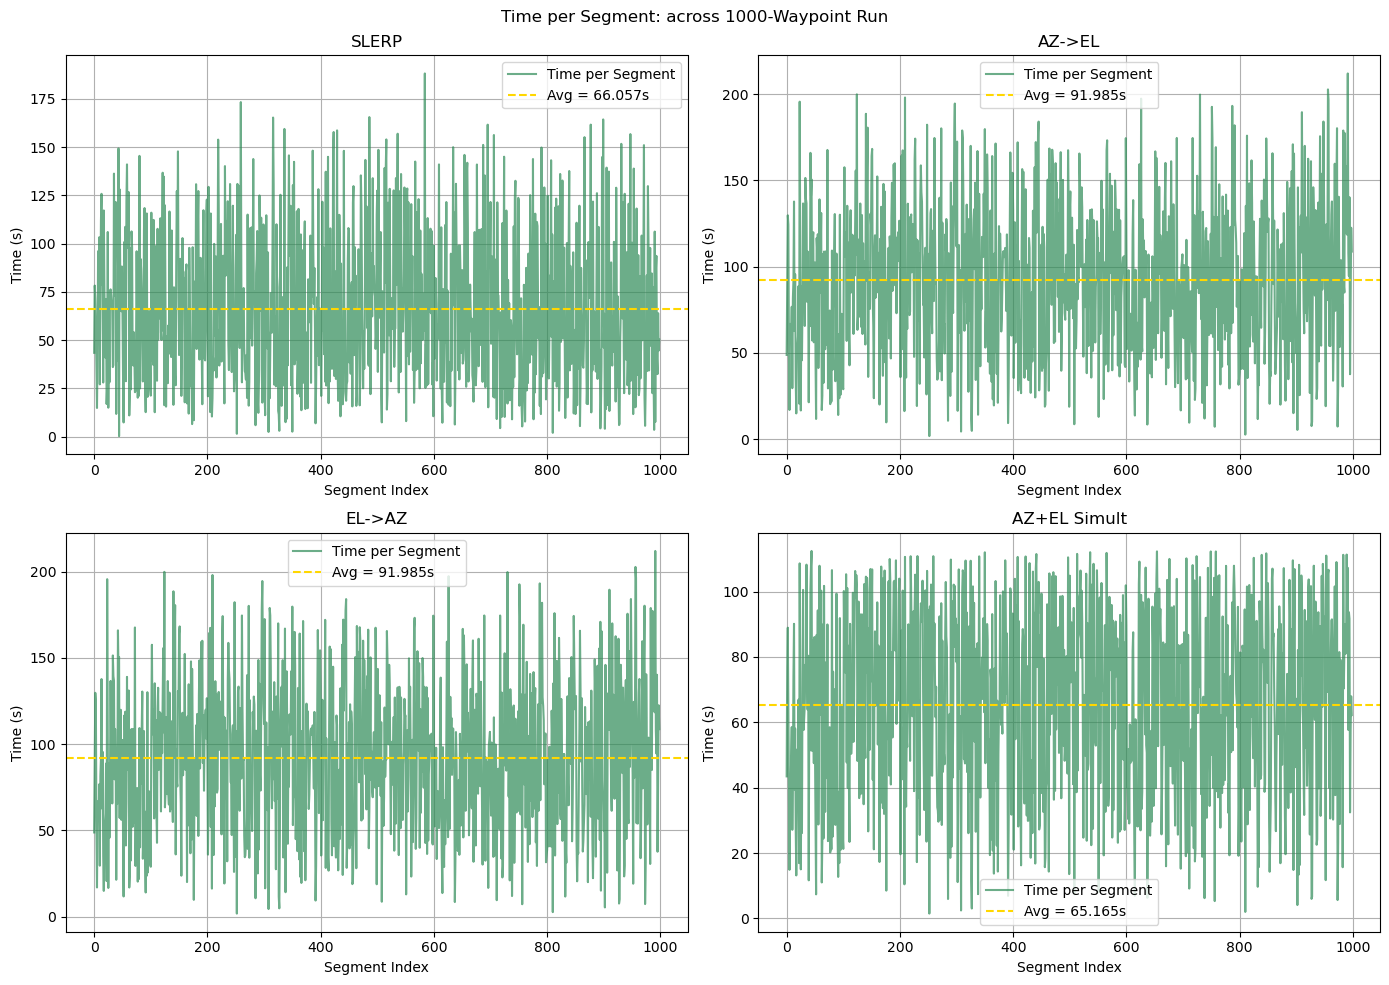

In [47]:
#NOTE PLOT LONG TERM BEHAVIOUR

def plot_time_per_segment(method_times: dict, n: int=10):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()

    for i, (method, times) in enumerate(method_times.items()):
        ax = axs[i]
        x = np.arange(len(times))
        y = np.array(times)

        ax.plot(x, y, label="Time per Segment", alpha=0.7, color="seagreen")
        ax.axhline(np.mean(y), color="gold", linestyle="--", label=f"Avg = {np.mean(y):.3f}s")

        ax.set_title(method)
        ax.set_ylabel("Time (s)")
        ax.set_xlabel("Segment Index")
        ax.grid(True)
        ax.legend()

    plt.suptitle(f"Time per Segment: across {n}-Waypoint Run")
    plt.tight_layout()
    plt.show()

N = 1000 # ADJUST HERE
wps = random_waypoints(N)
segment_times = benchmark_segment(wps)
plot_time_per_segment(segment_times, N)

In [43]:
#NOTE AVG DIFFS BETWEEN AXES

def average_delta(wps):
    total_az = 0
    total_el = 0
    for i in range(len(wps) - 1):
        az1, el1 = wps[i]
        az2, el2 = wps[i + 1]
        delta_az = min(abs(az2 - az1), 360 - abs(az2 - az1))
        delta_el = abs(el2 - el1)
        total_az += delta_az
        total_el += delta_el
    return total_az / (len(wps) - 1), total_el / (len(wps) - 1)

print("fixed  avg deltas", average_delta(waypoints))
print("random avg deltas", average_delta(wps))

fixed  avg deltas (110.625, 29.375)
random avg deltas (87.51568182529138, 50.18024352188744)


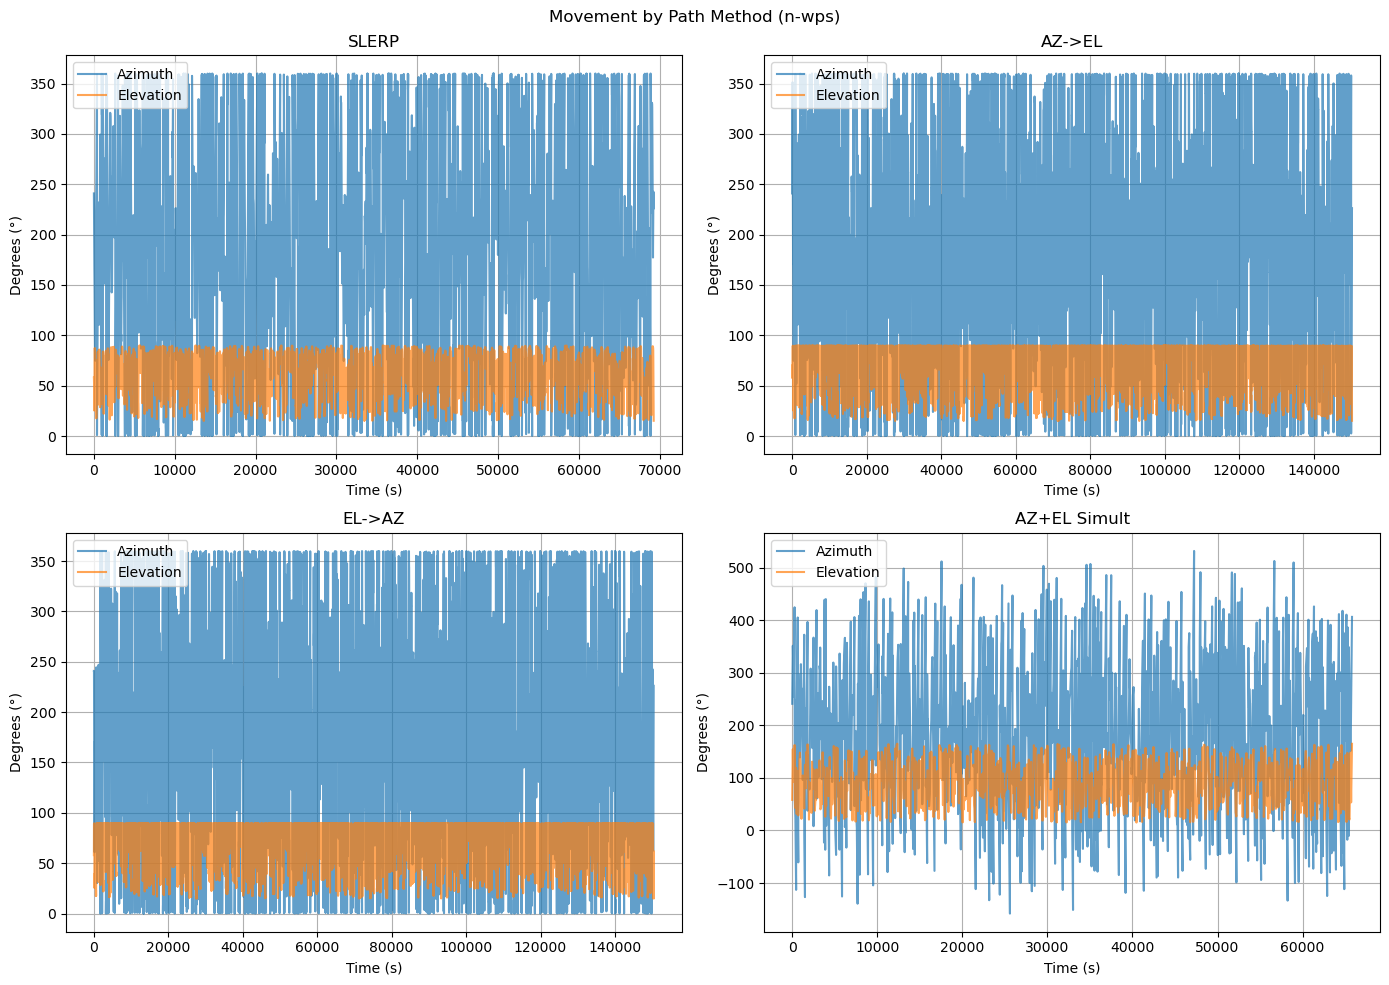

In [48]:
# idfk what i did there
# Move teelscope for method wps-many times
def n_wps(method_fn_dict, wps):
    results = {}

    for method, path_builder in method_fn_dict.items():
        full_path = []
        cumulative_time = []
        current_time = 0.0

        for i in range(len(wps) - 1):
            segment = path_builder(wps[i], wps[i + 1])
            for j, point in enumerate(segment):
                if j == 0 and len(full_path) > 0:
                    continue # avoid duplicates
                full_path.append(point)

                if len(full_path) == 1:
                    cumulative_time.append(0.0)
                else:
                    dt = movement_time(full_path[-2], full_path[-1])
                    current_time += dt
                    cumulative_time.append(current_time)
        
        az, el = zip(*full_path)
        results[method] = {"time": cumulative_time, "az": az, "el": el}

    return results




# execution of many waypoints (might take a while)
wps = random_waypoints(1000)

method_fn_dict = {
    "SLERP": lambda s, e: slerp_path(*s, *e, steps=100),
    "AZ->EL": lambda s, e: axis_aligned_paths(s, e)[0][1],
    "EL->AZ": lambda s, e: axis_aligned_paths(s, e)[1][1],
    "AZ+EL Simult": lambda s, e: simultaneous_az_el_path(s, e, steps=100)
}

exec_data = n_wps(method_fn_dict, wps)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, (method, data) in enumerate(exec_data.items()):
    ax = axs[i]
    ax.plot(data["time"], data["az"], label="Azimuth", alpha=0.7)
    ax.plot(data["time"], data["el"], label="Elevation", alpha=0.7)
    ax.set_title(f"{method}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Degrees (°)")
    ax.grid(True)
    ax.legend()

plt.suptitle("Movement by Path Method (n-wps)")
plt.tight_layout()
plt.show
print()